In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
device='cuda:0' if torch.cuda.is_available() else 'cpu'

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


In [4]:
chocholateDir='ChocolateH/'
poppyDir='Pereg/'

In [6]:
# transf=transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ])

# fullDs=datasets.ImageFolder('Data',transform=transf)
# # dl=torch.utils.data.DataLoader(ds,shuffle=True)


In [44]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'Data/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes



In [7]:
# valSplit=0.2
# valLen=int(valSplit*len(fullDs))
# trainLen=len(fullDs)-valLen
# trainSet,valSet=torch.utils.data.random_split(fullDs,[trainLen,valLen])
# dataset_sizes={'train':trainLen,'val':valLen}
# trainLoader=torch.utils.data.DataLoader(trainSet,shuffle=True)
# valLoader=torch.utils.data.DataLoader(valSet,shuffle=True)
# loaderDict={'train': trainLoader,'val':valLoader}

In [6]:
def train_model(model,dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [49]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
# optimizer_ft = optim.SGD(model_conv.fc.parameters(), lr=0.01,momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [50]:
model_ft = train_model(model_ft,dataloaders, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.2459 Acc: 0.6613
val Loss: 5.5281 Acc: 0.4828

Epoch 1/24
----------
train Loss: 0.6970 Acc: 0.6774
val Loss: 0.7866 Acc: 0.6897

Epoch 2/24
----------
train Loss: 0.6674 Acc: 0.6048
val Loss: 1.4894 Acc: 0.6207

Epoch 3/24
----------
train Loss: 0.6855 Acc: 0.6774
val Loss: 0.7613 Acc: 0.5862

Epoch 4/24
----------
train Loss: 0.6941 Acc: 0.6371
val Loss: 0.9994 Acc: 0.6207

Epoch 5/24
----------
train Loss: 0.5626 Acc: 0.7177
val Loss: 1.0910 Acc: 0.6207

Epoch 6/24
----------
train Loss: 0.5810 Acc: 0.7419
val Loss: 0.6340 Acc: 0.7241

Epoch 7/24
----------
train Loss: 0.5805 Acc: 0.7581
val Loss: 0.6156 Acc: 0.6552

Epoch 8/24
----------
train Loss: 0.4990 Acc: 0.7500
val Loss: 0.5792 Acc: 0.7241

Epoch 9/24
----------
train Loss: 0.4549 Acc: 0.7984
val Loss: 0.6017 Acc: 0.6897

Epoch 10/24
----------
train Loss: 0.4700 Acc: 0.7742
val Loss: 0.6534 Acc: 0.6207

Epoch 11/24
----------
train Loss: 0.4525 Acc: 0.7984
val Loss: 0.6639 Acc: 0.6207

Ep

In [51]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001,momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [52]:
model_conv = train_model(model_conv,dataloaders, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=100)


Epoch 0/99
----------
train Loss: 0.7852 Acc: 0.5403
val Loss: 0.6923 Acc: 0.5862

Epoch 1/99
----------
train Loss: 0.7751 Acc: 0.6371
val Loss: 0.7076 Acc: 0.5172

Epoch 2/99
----------
train Loss: 0.6563 Acc: 0.6371
val Loss: 1.4902 Acc: 0.4828

Epoch 3/99
----------
train Loss: 0.9363 Acc: 0.6048
val Loss: 0.7519 Acc: 0.4828

Epoch 4/99
----------
train Loss: 0.6707 Acc: 0.6694
val Loss: 1.0363 Acc: 0.5862

Epoch 5/99
----------
train Loss: 0.6706 Acc: 0.6532
val Loss: 0.9056 Acc: 0.4138

Epoch 6/99
----------
train Loss: 0.6671 Acc: 0.7016
val Loss: 1.2028 Acc: 0.5172

Epoch 7/99
----------
train Loss: 0.5377 Acc: 0.7339
val Loss: 0.8115 Acc: 0.5172

Epoch 8/99
----------
train Loss: 0.4136 Acc: 0.8226
val Loss: 0.9557 Acc: 0.4483

Epoch 9/99
----------
train Loss: 0.3939 Acc: 0.7742
val Loss: 0.8189 Acc: 0.4828

Epoch 10/99
----------
train Loss: 0.4087 Acc: 0.7742
val Loss: 0.8133 Acc: 0.4828

Epoch 11/99
----------
train Loss: 0.4505 Acc: 0.8226
val Loss: 0.7710 Acc: 0.5172

Ep

val Loss: 0.7836 Acc: 0.5172

Epoch 98/99
----------
train Loss: 0.3942 Acc: 0.8548
val Loss: 0.8027 Acc: 0.4483

Epoch 99/99
----------
train Loss: 0.4062 Acc: 0.8065
val Loss: 0.8282 Acc: 0.4483

Training complete in 7m 53s
Best val Acc: 0.620690


In [28]:
class meanModule(nn.Module):
    def __init__(self,modList):
        super(meanModule,self).__init__()
        self.modList=modList
    def forward(self,x):
        acc=0
        for m in self.modList:
            acc+=m(x)
        acc/=len(self.modList)
        return acc
mm=meanModule([model_conv,model_ft])


In [39]:
_,a=torch.topk(mm(x),k=1)
a.item()

0

**************************


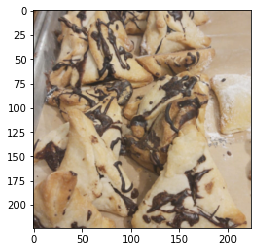

GT:  0


C:\Users\Matan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


FT Predict:  tensor([[0.7268, 0.2732]], device='cuda:0', grad_fn=<SoftmaxBackward>)


C:\Users\Matan\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


Conv Predict:  tensor([[0.7238, 0.2762]], device='cuda:0', grad_fn=<SoftmaxBackward>)


C:\Users\Matan\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


Mean Predict:  tensor([[0.7253, 0.2747]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Corr
**************************


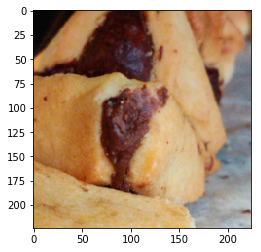

GT:  0
FT Predict:  tensor([[0.5369, 0.4631]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Conv Predict:  tensor([[0.8798, 0.1202]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Mean Predict:  tensor([[0.7445, 0.2555]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Corr
**************************


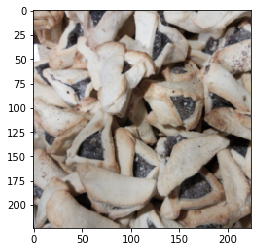

GT:  0
FT Predict:  tensor([[0.3620, 0.6380]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Conv Predict:  tensor([[0.6514, 0.3486]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Mean Predict:  tensor([[0.5073, 0.4927]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Corr
**************************


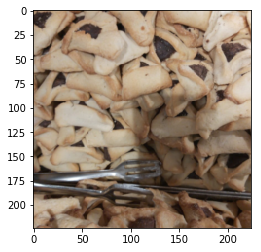

GT:  0
FT Predict:  tensor([[0.7265, 0.2735]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Conv Predict:  tensor([[0.5308, 0.4692]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Mean Predict:  tensor([[0.6342, 0.3658]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Corr
**************************


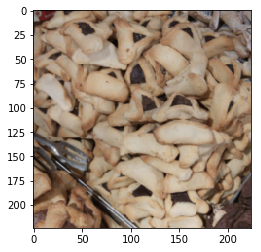

GT:  0
FT Predict:  tensor([[0.7424, 0.2576]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Conv Predict:  tensor([[0.8222, 0.1778]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Mean Predict:  tensor([[0.7850, 0.2150]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Corr
**************************


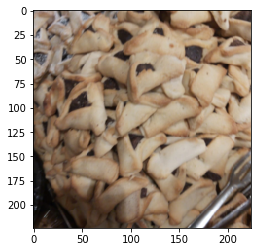

GT:  0
FT Predict:  tensor([[0.8061, 0.1939]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Conv Predict:  tensor([[0.5595, 0.4405]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Mean Predict:  tensor([[0.6967, 0.3033]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Corr
**************************


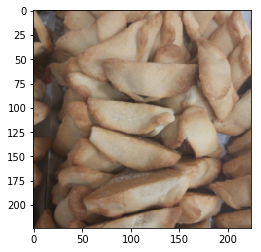

GT:  0
FT Predict:  tensor([[0.7515, 0.2485]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Conv Predict:  tensor([[0.4958, 0.5042]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Mean Predict:  tensor([[0.6330, 0.3670]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Corr
**************************


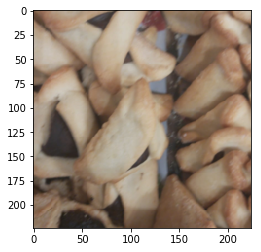

GT:  0
FT Predict:  tensor([[0.7848, 0.2152]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Conv Predict:  tensor([[0.5463, 0.4537]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Mean Predict:  tensor([[0.6770, 0.3230]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Corr
**************************


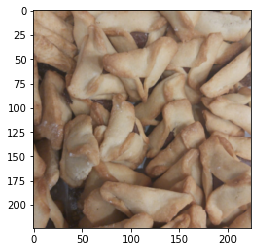

GT:  0
FT Predict:  tensor([[0.8419, 0.1581]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Conv Predict:  tensor([[0.6817, 0.3183]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Mean Predict:  tensor([[0.7715, 0.2285]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Corr
**************************


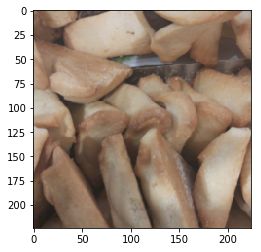

GT:  0
FT Predict:  tensor([[0.8569, 0.1431]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Conv Predict:  tensor([[0.7929, 0.2071]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Mean Predict:  tensor([[0.8272, 0.1728]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Corr
**************************


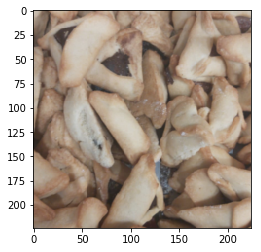

GT:  0
FT Predict:  tensor([[0.8147, 0.1853]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Conv Predict:  tensor([[0.6152, 0.3848]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Mean Predict:  tensor([[0.7261, 0.2739]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Corr
**************************


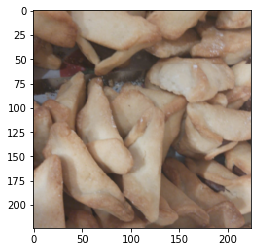

GT:  0
FT Predict:  tensor([[0.8155, 0.1845]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Conv Predict:  tensor([[0.5686, 0.4314]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Mean Predict:  tensor([[0.7071, 0.2929]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Corr
**************************


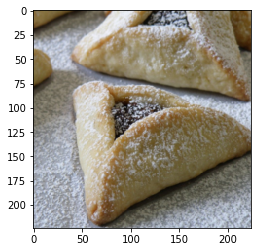

GT:  0
FT Predict:  tensor([[0.6666, 0.3334]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Conv Predict:  tensor([[0.5227, 0.4773]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Mean Predict:  tensor([[0.5968, 0.4032]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Corr
**************************


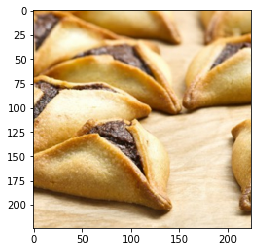

GT:  0
FT Predict:  tensor([[0.8199, 0.1801]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Conv Predict:  tensor([[0.9822, 0.0178]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Mean Predict:  tensor([[0.9407, 0.0593]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Corr
**************************


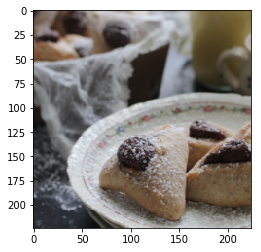

GT:  0
FT Predict:  tensor([[0.3444, 0.6556]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Conv Predict:  tensor([[0.5780, 0.4220]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Mean Predict:  tensor([[0.4590, 0.5410]], device='cuda:0', grad_fn=<SoftmaxBackward>)
**************************


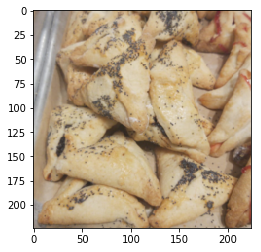

GT:  1
FT Predict:  tensor([[0.7713, 0.2287]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Conv Predict:  tensor([[0.5607, 0.4393]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Mean Predict:  tensor([[0.6748, 0.3252]], device='cuda:0', grad_fn=<SoftmaxBackward>)
**************************


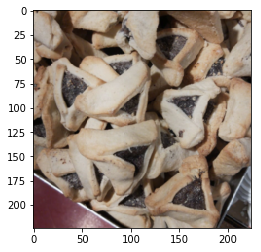

GT:  1
FT Predict:  tensor([[0.2839, 0.7161]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Conv Predict:  tensor([[0.6893, 0.3107]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Mean Predict:  tensor([[0.4840, 0.5160]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Corr
**************************


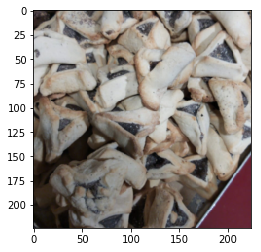

GT:  1
FT Predict:  tensor([[0.3256, 0.6744]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Conv Predict:  tensor([[0.9043, 0.0957]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Mean Predict:  tensor([[0.6811, 0.3189]], device='cuda:0', grad_fn=<SoftmaxBackward>)
**************************


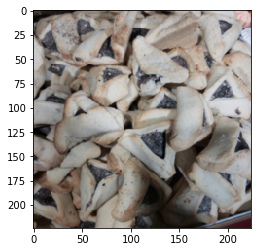

GT:  1
FT Predict:  tensor([[0.3578, 0.6422]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Conv Predict:  tensor([[0.5013, 0.4987]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Mean Predict:  tensor([[0.4280, 0.5720]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Corr
**************************


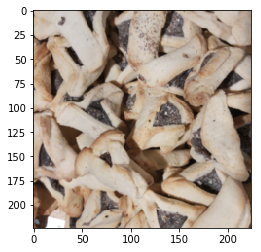

GT:  1
FT Predict:  tensor([[0.6249, 0.3751]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Conv Predict:  tensor([[0.4618, 0.5382]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Mean Predict:  tensor([[0.5445, 0.4555]], device='cuda:0', grad_fn=<SoftmaxBackward>)
**************************


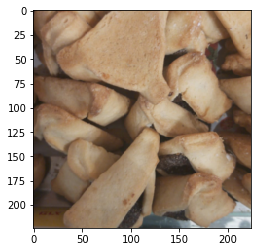

GT:  1
FT Predict:  tensor([[0.7641, 0.2359]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Conv Predict:  tensor([[0.5453, 0.4547]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Mean Predict:  tensor([[0.6634, 0.3366]], device='cuda:0', grad_fn=<SoftmaxBackward>)
**************************


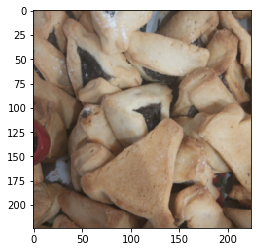

GT:  1
FT Predict:  tensor([[0.8124, 0.1876]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Conv Predict:  tensor([[0.8812, 0.1188]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Mean Predict:  tensor([[0.8500, 0.1500]], device='cuda:0', grad_fn=<SoftmaxBackward>)
**************************


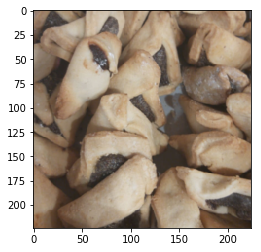

GT:  1
FT Predict:  tensor([[0.7622, 0.2378]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Conv Predict:  tensor([[0.7681, 0.2319]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Mean Predict:  tensor([[0.7651, 0.2349]], device='cuda:0', grad_fn=<SoftmaxBackward>)
**************************


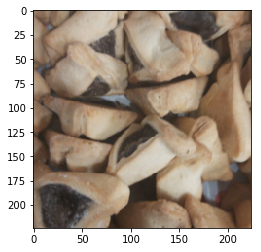

GT:  1
FT Predict:  tensor([[0.7515, 0.2485]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Conv Predict:  tensor([[0.2453, 0.7547]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Mean Predict:  tensor([[0.4978, 0.5022]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Corr
**************************


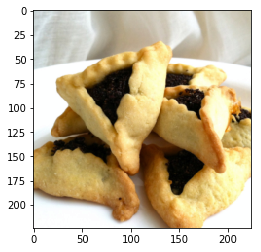

GT:  1
FT Predict:  tensor([[0.1805, 0.8195]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Conv Predict:  tensor([[0.0791, 0.9209]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Mean Predict:  tensor([[0.1210, 0.8790]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Corr
**************************


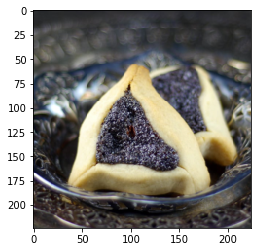

GT:  1
FT Predict:  tensor([[0.0014, 0.9986]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Conv Predict:  tensor([[0.0101, 0.9899]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Mean Predict:  tensor([[0.0037, 0.9963]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Corr
**************************


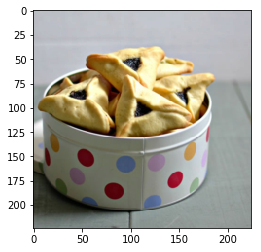

GT:  1
FT Predict:  tensor([[0.1711, 0.8289]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Conv Predict:  tensor([[0.2739, 0.7261]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Mean Predict:  tensor([[0.2182, 0.7818]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Corr
**************************


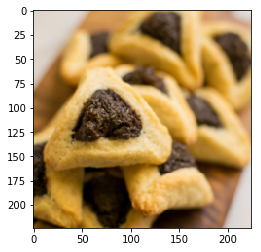

GT:  1
FT Predict:  tensor([[0.5820, 0.4180]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Conv Predict:  tensor([[0.4806, 0.5194]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Mean Predict:  tensor([[0.5316, 0.4684]], device='cuda:0', grad_fn=<SoftmaxBackward>)
**************************


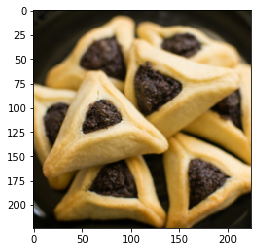

GT:  1
FT Predict:  tensor([[0.0696, 0.9304]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Conv Predict:  tensor([[0.0134, 0.9866]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Mean Predict:  tensor([[0.0309, 0.9691]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Corr
Mean Acc:  0.7241379310344828


In [45]:
iterLoad=iter(image_datasets['val'])
nCorr=0
nTot=0
for i in range(len(image_datasets['val'])):
    x,y=next(iterLoad)
    print('**************************')
    imshow(x)
    x=torch.Tensor(x).to(device).unsqueeze(0)
    s=nn.Softmax()
    print('GT: ',y)
    print('FT Predict: ',s(model_ft(x)))
    print('Conv Predict: ',s(model_conv(x)))
    print('Mean Predict: ',s(mm(x)))
    _,a=torch.topk(mm(x),k=1)
    if a.item()==y:
        nCorr+=1
        print('Corr')
    nTot+=1
print('Mean Acc: ',nCorr/nTot)